# prep

In [32]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data(dir_path):
    file_path = dir_path.replace('\\', '/')
    data = sio.loadmat(file_path + '/trace_trial_stim.mat')
    
    stim_seq = data['stim_seq']
    stim_id = [i[0] for i in stim_seq]
    trace_by_trial = data['trace_by_trial']

    ncell = trace_by_trial.shape[0]
    nstim = len(np.unique(stim_id))
    ntrial = trace_by_trial.shape[1]
    nframe = trace_by_trial.shape[2]
    print(ncell, nstim, ntrial, nframe)

    return stim_id, trace_by_trial, # ncell, nstim, ntrial, nframe


def calc_trace_stim(trace_by_trial, stim_id):
    trace_avg_cell = np.mean(np.mean(trace_by_trial, axis=0), axis=0)
    trace_stim_avg = []
    # trace_stim_std = []
    # trace_stim_sem = []

    for i in np.unique(stim_id):
        trace_istim_avg = np.mean(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1) # ncell x nframe
        trace_istim_avg = np.mean(trace_istim_avg, axis=0) # nframe
        # trace_istim_std = np.std(trace_by_trial[:, np.where(stim_id == i)[0]], axis=1)
        # trace_istim_sem = trace_istim_std / np.sqrt(len(np.where(stim_id == i)[0]))

        trace_stim_avg.append(trace_istim_avg)
        # trace_stim_std.append(trace_istim_std)
        # trace_stim_sem.append(trace_istim_sem)

    print(len(trace_stim_avg), trace_stim_avg[0].shape)
    return trace_avg_cell, trace_stim_avg

# compare trace

In [4]:
# i1369 V1 high res, cellpose
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310_cellpose'
stim_id_cellpose, trace_by_trial_cellpose = load_data(dir_path)
trace_avg_cell_cellpose, trace_stim_avg_cellpose = calc_trace_stim(trace_by_trial_cellpose, stim_id_cellpose)

# i1369 V1 high res, manual
dir_path = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1369_220310'
stim_id_manual, trace_by_trial_manual = load_data(dir_path)
trace_avg_cell_manual, trace_stim_avg_manual = calc_trace_stim(trace_by_trial_manual, stim_id_manual)

114 30 511 156
30 (156,)
155 30 511 156
30 (156,)


In [26]:
# normalize trace to same max min
trace_avg_cell_cellpose_norm = (trace_avg_cell_cellpose - np.min(trace_avg_cell_cellpose)) / (np.max(trace_avg_cell_cellpose) - np.min(trace_avg_cell_cellpose))
trace_avg_cell_manual_norm = (trace_avg_cell_manual - np.min(trace_avg_cell_manual)) / (np.max(trace_avg_cell_manual) - np.min(trace_avg_cell_manual))

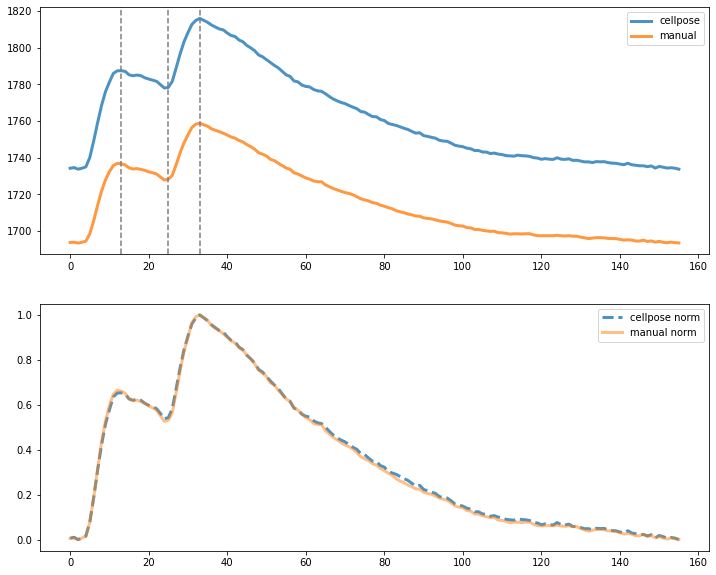

In [31]:
# try no normalization
plt.figure(figsize=(12, 10))

plt.subplot(2,1,1)
plt.plot(trace_avg_cell_cellpose, alpha=0.8, linewidth=3) # - 50
plt.plot(trace_avg_cell_manual, alpha=0.8, linewidth=3)

plt.axvline(x=np.argmax(trace_avg_cell_cellpose[:25]), color='gray', linestyle='--')
plt.axvline(x=np.argmin(trace_avg_cell_cellpose[25:30]) + 25, color='gray', linestyle='--')
plt.axvline(x=np.argmax(trace_avg_cell_cellpose), color='gray', linestyle='--')
plt.legend(['cellpose', 'manual'])

plt.subplot(2,1,2)
plt.plot(trace_avg_cell_cellpose_norm, alpha=0.8, linewidth=3, linestyle='--')
plt.plot(trace_avg_cell_manual_norm, alpha=0.5, linewidth=3)
plt.legend(['cellpose norm', 'manual norm'])

# compare resp

In [53]:
d = {'mouse': [1369, 1369], 'date': ['220310', '220310_cellpose'], 'area': ['V1', 'V1']}
meta = pd.DataFrame(data=d)
print(meta)

   mouse             date area
0   1369           220310   V1
1   1369  220310_cellpose   V1


In [153]:
nset = len(meta.index); ncell = []; nori = 30; nframe_trial = 156
dir_name = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')

def load_dfof(iset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])
    dfof = sio.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    dfof_ad = dfof['dfof_ad']
    dfof_tg = dfof['dfof_tg']
    ncell = dfof['dfof_ad'].shape[0]
    return dfof_ad, dfof_tg, ncell

def threshold_dfof(dfof_ad, dfof_tg):
    thres_perc = 1
    thres_low = np.percentile(dfof_ad.flatten(), thres_perc)
    thres_high = np.percentile(dfof_ad.flatten(), 100-thres_perc)
    dfof_ad_thres = dfof_ad.copy()
    dfof_ad_thres[dfof_ad_thres < thres_low] = np.nan
    dfof_ad_thres[dfof_ad_thres > thres_high] = np.nan
    dfof_tg_thres = dfof_tg.copy()
    dfof_tg_thres[dfof_tg_thres < thres_low] = np.nan # threshold resp_tg by resp_tg
    dfof_tg_thres[dfof_tg_thres > thres_high] = np.nan
    return dfof_ad_thres, dfof_tg_thres

def calc_adp(dfof_ad, dfof_tg):
    adp = (dfof_tg - dfof_ad) / (dfof_tg + dfof_ad + 1e-7) # changed definition of adp to (tg - ad) / (tg + ad)
    return adp

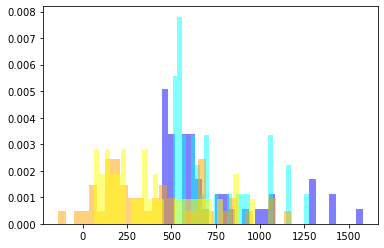

In [148]:
# check if extreme value of dfof_ad and dfof_tg co-occur -> not really
# conclusion: should threshold both dfof_ad and dfof_tg at top / bottom 5% (substitute with np.nan)

dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(0)
dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(1)
large_ad_cellpose_id = dfof_ad_cellpose.flatten() > np.percentile(dfof_ad_cellpose.flatten(), 99)
large_ad_manual_id = dfof_ad_manual.flatten() > np.percentile(dfof_ad_manual.flatten(), 99)

large_ad_cellpose = dfof_ad_cellpose.flatten()[large_ad_cellpose_id]
large_ad_manual = dfof_ad_manual.flatten()[large_ad_manual_id]
large_ad_tg_cellpose = dfof_tg_cellpose.flatten()[large_ad_cellpose_id] # tg corresponding to large_ad
large_ad_tg_manual = dfof_tg_manual.flatten()[large_ad_manual_id]

plt.hist(large_ad_cellpose.flatten(), bins=30, alpha=0.5, density=True, color='b');
plt.hist(large_ad_manual.flatten(), bins=30, alpha=0.5, density=True, color='cyan');
plt.hist(large_ad_tg_cellpose.flatten(), bins=30, alpha=0.5, density=True, color='orange');
plt.hist(large_ad_tg_manual.flatten(), bins=30, alpha=0.5, density=True, color='yellow');

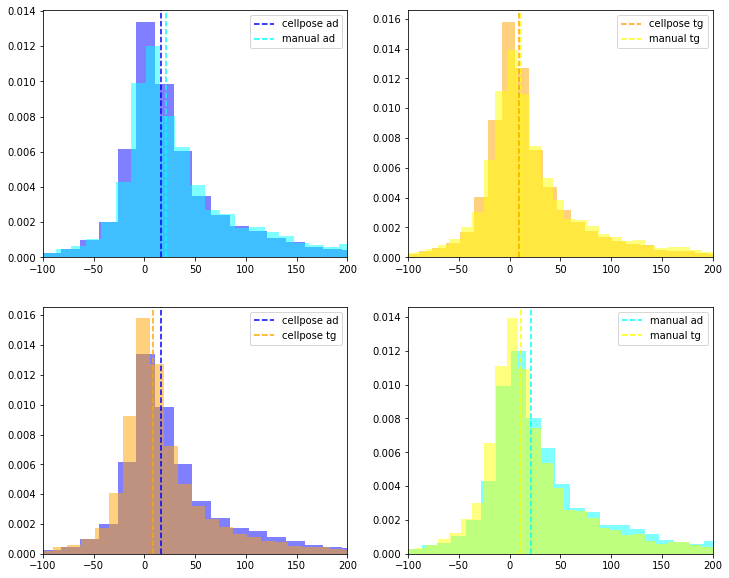

In [122]:
# check distribution of response to adapter and target, original value w/o thresholding

dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(0)
dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(1)

dfof_ad_cellpose_median = np.nanmedian(dfof_ad_cellpose.flatten())
dfof_ad_manual_median = np.nanmedian(dfof_ad_manual.flatten())
dfof_tg_cellpose_median = np.nanmedian(dfof_tg_cellpose.flatten())
dfof_tg_manual_median = np.nanmedian(dfof_tg_manual.flatten())

xlow = -100
xhigh = 200

plt.figure(figsize=(12, 10))
plt.subplot(2,2,1)
plt.hist(dfof_ad_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
plt.axvline(x=dfof_ad_cellpose_median, color='b', linestyle='--')
plt.hist(dfof_ad_manual.flatten(), bins=100, alpha=0.5, density=True, color='cyan');
plt.axvline(x=dfof_ad_manual_median, color='cyan', linestyle='--')
plt.xlim([xlow, xhigh])
plt.legend(['cellpose ad', 'manual ad'])

plt.subplot(2,2,2)
plt.hist(dfof_tg_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='orange');
plt.axvline(x=dfof_tg_cellpose_median, color='orange', linestyle='--')
plt.hist(dfof_tg_manual.flatten(), bins=100, alpha=0.5, density=True, color='yellow');
plt.axvline(x=dfof_tg_manual_median, color='yellow', linestyle='--')
plt.xlim([xlow, xhigh])
plt.legend(['cellpose tg', 'manual tg'])

plt.subplot(2,2,3)
plt.hist(dfof_ad_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
plt.axvline(x=dfof_ad_cellpose_median, color='b', linestyle='--')
plt.hist(dfof_tg_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='orange');
plt.axvline(x=dfof_tg_cellpose_median, color='orange', linestyle='--')
plt.xlim([xlow, xhigh])
plt.legend(['cellpose ad', 'cellpose tg'])

plt.subplot(2,2,4)
plt.hist(dfof_ad_manual.flatten(), bins=100, alpha=0.5, density=True, color='cyan');
plt.axvline(x=dfof_ad_manual_median, color='cyan', linestyle='--')
plt.hist(dfof_tg_manual.flatten(), bins=100, alpha=0.5, density=True, color='yellow');
plt.axvline(x=dfof_tg_manual_median, color='yellow', linestyle='--')
plt.xlim([xlow, xhigh])
plt.legend(['manual ad', 'manual tg']);

# compare adp

In [158]:
dfof_ad_cellpose, dfof_tg_cellpose, ncell_cellpose = load_dfof(0)
dfof_ad_cellpose, dfof_tg_cellpose = threshold_dfof(dfof_ad_cellpose, dfof_tg_cellpose) # cellpose did not filter by vis-driven
adp_cellpose = calc_adp(dfof_ad_cellpose, dfof_tg_cellpose)

dfof_ad_manual, dfof_tg_manual, ncell_manual = load_dfof(1)
dfof_ad_manual, dfof_tg_manual = threshold_dfof(dfof_ad_manual, dfof_tg_manual)
adp_manual = calc_adp(dfof_ad_manual, dfof_tg_manual)

adp_manual.shape, adp_manual.flatten().shape

((114, 30), (3420,))

In [160]:
np.nanmedian(adp_manual.flatten()), np.nanmedian(adp_cellpose.flatten()), np.nanmean(adp_manual.flatten()), np.nanmean(adp_cellpose.flatten())

(-0.15320007251398496,
 -0.13025300150959163,
 -0.28253813748603007,
 -0.10708218641945814)

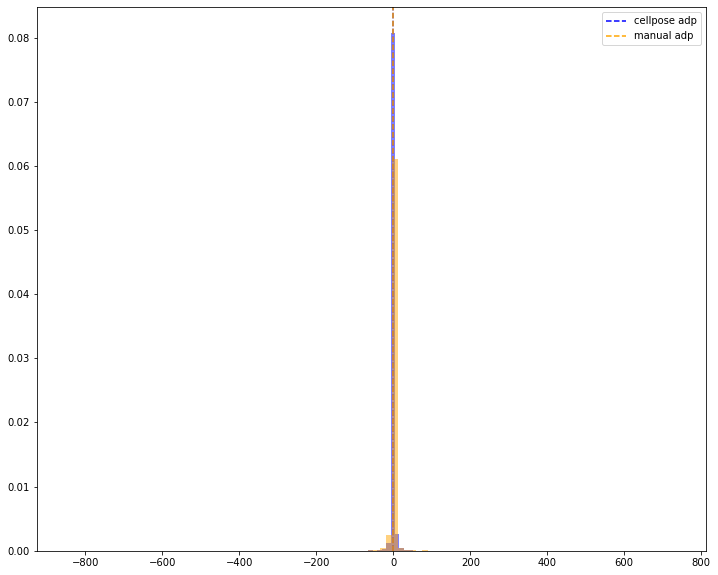

In [161]:
plt.figure(figsize=(12, 10))
plt.hist(adp_cellpose.flatten(), bins=100, alpha=0.5, density=True, color='b');
plt.axvline(x=np.nanmedian(adp_cellpose.flatten()), color='b', linestyle='--')

plt.hist(adp_manual.flatten(), bins=100, alpha=0.5, density=True, color='orange');
plt.axvline(x=np.nanmedian(adp_manual.flatten()), color='orange', linestyle='--')
# plt.xlim([xlow, xhigh])
plt.legend(['cellpose adp', 'manual adp'])

In [171]:
adp_cellpose.flatten().shape, adp_cellpose.shape

((4650,), (155, 30))

,total_bill,tip,sex,smoker,day,time,size
93,16.32,4.30,Female,Yes,Fri,Dinner,2
16,10.33,1.67,Female,No,Sun,Dinner,3
98,21.01,3.00,Male,Yes,Fri,Dinner,2
173,31.85,3.18,Male,Yes,Sun,Dinner,2
113,23.95,2.55,Male,No,Sun,Dinner,2


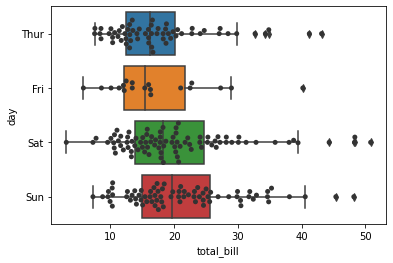

In [170]:
tips = sns.load_dataset("tips")
ax = sns.boxplot(x="total_bill", y="day", data=tips) # , whis=np.inf
ax = sns.swarmplot(x="total_bill", y="day", data=tips, color=".2")
tips.sample(5)